# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *


In [2]:
codes_list = ["wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full","cmssim","wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full"]

#codes_list = ["cmssim"]
uncut_data = {}
for code in codes_list:
    uncut_data[code] = np.load(f"compiled_data/{code}.npy")
    uncut_data[code] = np.nan_to_num(uncut_data[code])
    print(f"{code} has initial shape {uncut_data[code].shape}")

wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full has initial shape (6755, 13)
cmssim has initial shape (7433462, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full has initial shape (5653, 13)


## Visualize the data

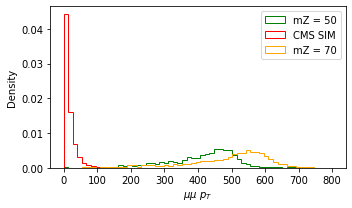

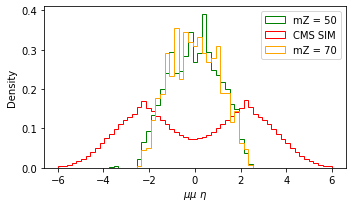

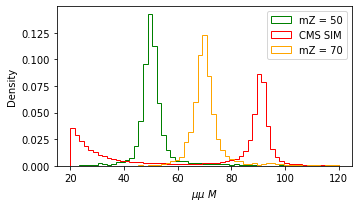

In [3]:
feature_set = [9, 10, 12]
    
hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype)
    




## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [4]:
# jet_cuts

jet_pt_cut = 15 
jet_eta_cut = 2.4

cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code][:,0] > jet_pt_cut) & (np.abs(uncut_data[code][:,1]) < jet_eta_cut) # MAKE SURE THE INDICES ARE OK
    cut_data[code] = uncut_data[code][pass_indices]
    print(f"{code} has shape {cut_data[code].shape} after cuts")
    

    

wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full has shape (6406, 13) after cuts
cmssim has shape (5746300, 13) after cuts
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full has shape (5433, 13) after cuts


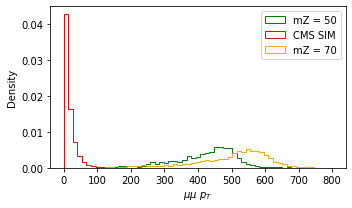

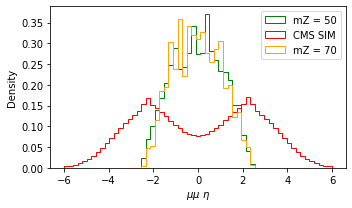

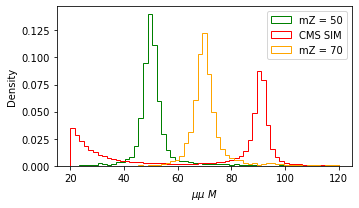

In [5]:
    
    
hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [6]:
band_bounds = {"SBL": [15, 35],
               "IBL": [35, 40],
               "SR": [40, 60],
               "IBH": [60, 65],
               "SBH": [65, 80],
                       }

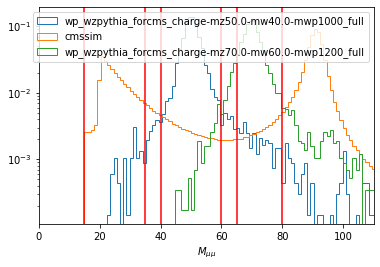

In [7]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code][:,-1], bins = np.linspace(15, 120, 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(0, 110)
plt.yscale("log")
plt.show()

In [8]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code][:,-1] > band_bounds[b][0]) & (cut_data[code][:,-1] < band_bounds[b][1])
        preproc_dicts[b][code] = cut_data[code][loc_pass_indices]

        print(f"{code} {b} has shape {preproc_dicts[b][code].shape}")
   
    
    

wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full SBL has shape (71, 13)
wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full IBL has shape (92, 13)
wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full SR has shape (5813, 13)
wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full IBH has shape (129, 13)
wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full SBH has shape (188, 13)
cmssim SBL has shape (1508072, 13)
cmssim IBL has shape (152168, 13)
cmssim SR has shape (301326, 13)
cmssim IBH has shape (53348, 13)
cmssim SBH has shape (234644, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full SBL has shape (0, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full IBL has shape (0, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full SR has shape (130, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full IBH has shape (437, 13)
wp_wzpythia_forcms_charge-mz70.0-mw60.0-mwp1200_full SBH has shape (4495, 13)


In [9]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Signal injection


In [10]:
signal_model = "wp_wzpythia_forcms_charge-mz50.0-mw40.0-mwp1000_full"

n_bkg_in_SR_total = preproc_dicts["SR"]["cmssim"].shape[0]
n_sig_in_SR_total = preproc_dicts["SR"][signal_model].shape[0]

print(f"{n_bkg_in_SR_total} B in SR, {n_sig_in_SR_total} S in SR")

# first calculate how many signal events to inject
desired_significance = 2
n_sig_inject_SR = int(np.sqrt(n_bkg_in_SR_total)*desired_significance)

frac_sig_to_inject = n_sig_inject_SR/n_sig_in_SR_total

num_signal_events_to_inject = {}

for b in bands:
    num_signal_events_to_inject[b] = int(frac_sig_to_inject*preproc_dicts[b][signal_model].shape[0])
    print(b, num_signal_events_to_inject[b])

301326 B in SR, 5813 S in SR
SBL 13
IBL 17
SR 1097
IBH 24
SBH 35


In [11]:
# then do the injection

from sklearn.utils import shuffle

preproc_dicts_s_inj = {}

for b in bands:
        
    sig_events_to_inject_inds = np.random.choice(range(preproc_dicts[b][signal_model].shape[0]), 
                                            size=num_signal_events_to_inject[b], replace=False)
    sig_events_to_inject = preproc_dicts[b][signal_model][sig_events_to_inject_inds]
    band_data = np.vstack((preproc_dicts[b]["cmssim"], sig_events_to_inject))
        
    preproc_dicts_s_inj[b] = shuffle(band_data)
    

## Preprocessing

Standard scaling is fine

In [12]:
save_scaler = True



In [40]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

#rescale_feats = [5, 6, 7, 8, 9]
rescale_feats = [9]

proc_dict_s_inj = {b:{} for b in bands}


if save_scaler:
    SB_all = np.vstack((preproc_dicts_s_inj["SBL"], preproc_dicts_s_inj["SBH"]))
    scaler = StandardScaler()
    scaler = scaler.fit(SB_all)
    with open(f"processed_data/scaler", "wb") as ofile:
        pickle.dump(scaler, ofile)
else:
    with open(f"processed_data/scaler", "rb") as ifile:
        scaler = pickle.load(ifile)
    
for b in bands:
    

    proc_dict_s_inj[b]["s_inj_data"] = scaler.transform(preproc_dicts_s_inj[b])
    for ii in rescale_feats:
         proc_dict_s_inj[b]["s_inj_data"][:,ii] = (proc_dict_s_inj[b]["s_inj_data"][:,ii]-22)/6



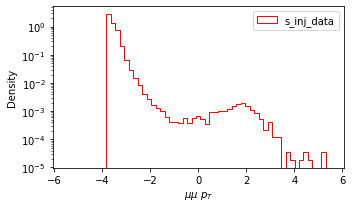

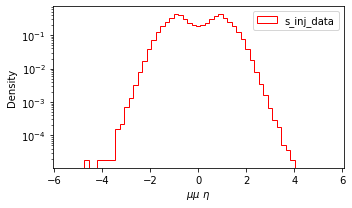

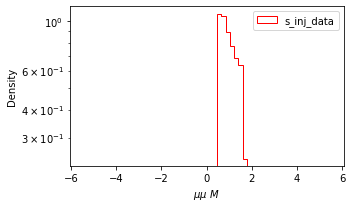

In [45]:
hist_all_features(["s_inj_data"], proc_dict_s_inj["SR"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True)


In [ ]:
#hist_all_features(codes_list, SB_data_procc, kwargs_dict, scaled_bins)


In [47]:
for code in codes_list:

    for b in bands:
    
        np.save(f"processed_data/s_inj_test_{b}.npy", proc_dict_s_inj[b]["s_inj_data"])

